# GFs for MNIST (Naive + Splines)

In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", False)

import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.transforms.parametric.mixture.logistic import InitMixtureLogisticCDF
from rbig_jax.transforms.parametric.mixture.gaussian import InitMixtureGaussianCDF
from rbig_jax.transforms.logit import InitLogitTransform
from rbig_jax.transforms.inversecdf import InitInverseGaussCDF
from rbig_jax.transforms.parametric.householder import InitHouseHolder
from distrax._src.bijectors.sigmoid import Sigmoid
from distrax._src.bijectors.inverse import Inverse

# Plot utilities
from rbig_jax.custom_types import ImageShape
from rbig_jax.plots import plot_image_grid


KEY = jax.random.PRNGKey(123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import corner
from IPython.display import HTML

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext lab_black
%matplotlib inline


%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
import wandb

wandb_logger = wandb.init(project="gf_mnist_naive", entity="ipl_uv")

wandb_logger.config.seed = 123

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ml4floods (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.28 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Demo Data

In this demonstration, we will be using the "mnist" dataset.

In [4]:
import tensorflow_datasets as tfds
from typing import Iterator, Mapping
import numpy as np

Batch = Mapping[str, np.ndarray]


def load_dataset(split: tfds.Split, batch_size: int) -> Iterator[Batch]:
    ds = tfds.load("mnist", split=split, shuffle_files=True)
    ds = ds.shuffle(buffer_size=10 * batch_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))

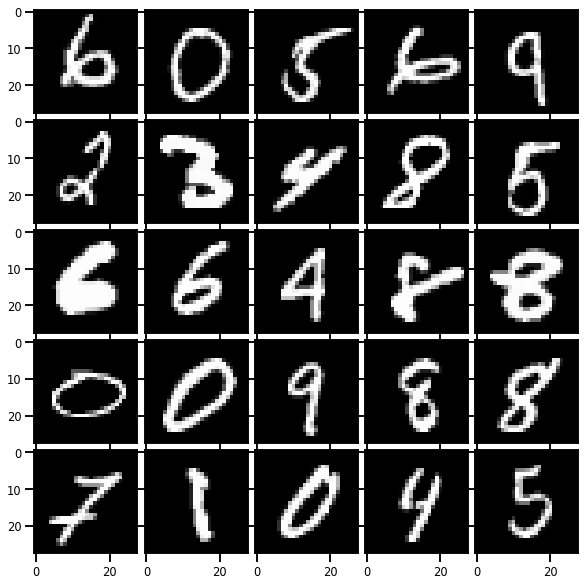

In [5]:
# train/valid dataset loaders
wandb_logger.config.batch_size = 128
n_init_samples = 1_000
train_ds = load_dataset(tfds.Split.TRAIN, 128)
init_ds = load_dataset(tfds.Split.TRAIN, n_init_samples)
valid_ds = load_dataset(tfds.Split.TEST, 128)

# demo batch
demo_batch = next(train_ds)

# plot batch of images
fig, ax = plot_image_grid(demo_batch["image"])

wandb.log({"demo_images": wandb.Image(plt)})

### Preprocessing Steps

1. Dequantize the variables

Basically add some uniform noise to help with training.

2. Normalize the pixels

We constrain the pixels to be from $[0, 256)$ to $[0, 1)$.

In [6]:
from typing import Optional
from chex import Array
from einops import rearrange

PRNGKey = Array


def prepare_data(batch: Batch, prng_key: Optional[PRNGKey] = None) -> Array:

    # select image from tfds
    data = batch["image"].astype(jnp.float32)

    # dequantize pixels (training only)
    if prng_key is not None:
        # Dequantize pixel values {0, 1, ..., 255} with uniform noise [0, 1).
        data += jax.random.uniform(prng_key, data.shape)

    # flatten image data
    data = rearrange(data, "B H W C -> B (H W C)")

    return data / 256.0  # Normalize pixel values from [0, 256) to [0, 1).

#### Demo

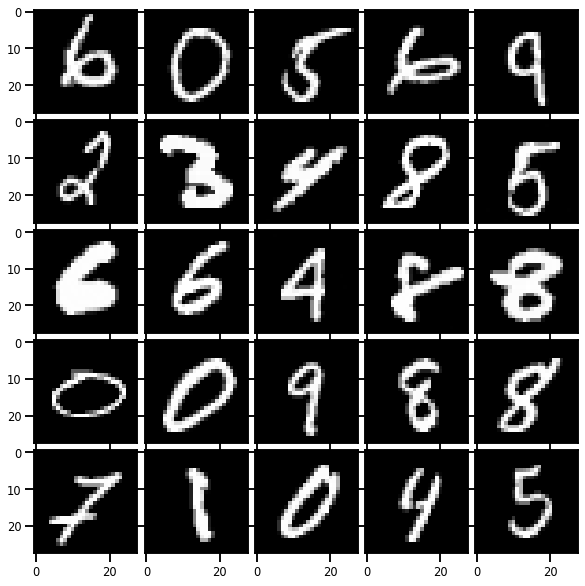

In [7]:
# create key
rng, prng_key = jax.random.split(KEY, num=2)

# prep the data
demo_data_prepped = prepare_data(demo_batch, prng_key=prng_key)

# plot image grid
image_shape = ImageShape(C=1, H=28, W=28)
fig, ax = plot_image_grid(demo_data_prepped, image_shape)

wandb.log({"demo_images_prepped": wandb.Image(plt)})

## Model

In [8]:
wandb_logger.config.model = "splines"

In [9]:
from rbig_jax.transforms.parametric.householder import InitHouseHolder
from rbig_jax.transforms.parametric.splines import InitPiecewiseRationalQuadraticCDF
from chex import Array
from distrax._src.distributions.normal import Normal
from rbig_jax.models.gaussflow import GaussianizationFlow
from rbig_jax.transforms.logit import InitLogitTransform, InitSigmoidTransform
import itertools


def init_gf_spline_model(
    shape: tuple,
    X: Array = None,
    n_blocks: int = 4,
    n_bins: int = 20,
    range_min: float = -10,
    range_max: float = 10,
    init_rotation: str = "pca",
    n_reflections: int = 10,
    plot_layers: bool = False,
    plot_blocks: bool = False,
    **kwargs,
):

    n_features = shape[0]
    rng = jax.random.PRNGKey(42)
    # rng, _ = jax.random.split(jax.random.PRNGKey(123), 2)

    #
    init_sigmoid_f = InitSigmoidTransform()
    init_logit_f = InitLogitTransform()

    # =====================
    # RQ Spline
    # ======================
    init_rq_f = InitPiecewiseRationalQuadraticCDF(
        n_bins=n_bins, range_min=range_min, range_max=range_max, **kwargs
    )
    # =====================
    # HouseHolder Transform
    # ======================
    n_reflections = n_reflections
    # initialize init function
    init_hh_f = InitHouseHolder(n_reflections=n_reflections, method=init_rotation)

    block_rngs = jax.random.split(rng, num=n_blocks)
    # rng = jax.random.split(jax.random.PRNGKey(42), n_blocks)
    # block_rngs = jax.random.split(jax.random.PRNGKey(42), n_blocks)

    itercount = itertools.count()
    bijectors = []

    X_g = X.copy()

    if plot_blocks:
        fig = corner.corner(np.array(X_g), color="red", hist_bin_factor=2)

    pbar = tqdm.tqdm(block_rngs)
    with pbar:
        for iblock, irng in enumerate(pbar):

            pbar.set_description(
                f"Initializing - Block: {iblock+1} | Layer {next(itercount)}"
            )

            # ======================
            # Sigmoid
            # ======================
            # intialize bijector and transformation
            X_g, layer = init_sigmoid_f.bijector_and_transform(inputs=X_g)

            # ======================
            # RQ Spline
            # ======================
            # create keys for all inits
            irng, irq_rng = jax.random.split(irng, 2)

            # intialize bijector and transformation
            X_g, layer = init_rq_f.bijector_and_transform(
                inputs=X_g, rng=irq_rng, shape=X.shape[1:]
            )

            # plot data
            if plot_layers and plot_blocks:
                fig = corner.corner(np.array(X_g), color="red", hist_bin_factor=2)

            # add bijector to list
            bijectors.append(layer)

            # ======================
            # Logit
            # ======================
            # intialize bijector and transformation
            X_g, layer = init_logit_f.bijector_and_transform(inputs=X_g)

            # ======================
            # HOUSEHOLDER
            # ======================
            pbar.set_description(
                f"Initializing - Block: {iblock+1} | Layer {next(itercount)}"
            )
            # create keys for all inits
            irng, hh_rng = jax.random.split(irng, 2)

            # intialize bijector and transformation
            X_g, layer = init_hh_f.bijector_and_transform(
                inputs=X_g, rng=hh_rng, n_features=n_features
            )

            bijectors.append(layer)

            # plot data
            if plot_blocks:
                fig = corner.corner(np.array(X_g), color="red", hist_bin_factor=2)

    # create base dist
    base_dist = Normal(jnp.zeros((n_features,)), jnp.ones((n_features,)))

    # create flow model
    gf_model = GaussianizationFlow(base_dist=base_dist, bijectors=bijectors)
    return gf_model

In [10]:
# initialization data
init_ds = load_dataset(tfds.Split.TRAIN, n_init_samples)
init_ds = next(init_ds)
init_data_prepped = prepare_data(init_ds, prng_key=prng_key)
X_init = np.array(init_data_prepped)

# marginal uniformization
n_bins = 32
range_min = 0.0
range_max = 1.0
boundary_slopes = "unconstrained"
identity_init = False

# rotation transformation
n_reflections = 50
init_rotation = "random"

# nn params
n_blocks = 12
plot_layers = False
plot_blocks = False

In [11]:
# init model
gf_model_ = init_gf_spline_model(
    shape=X_init.shape[1:],
    X=X_init,
    n_blocks=n_blocks,
    n_bins=n_bins,
    range_min=range_min,
    range_max=range_max,
    boundary_slopes=boundary_slopes,
    identity_init=identity_init,
    init_rotation=init_rotation,
    n_reflections=n_reflections,
    plot_layers=plot_layers,
    plot_blocks=plot_blocks,
)

Initializing - Block: 12 | Layer 23: 100%|██████████| 12/12 [00:09<00:00,  1.33it/s]


In [12]:
from rbig_jax.models import GaussianizationFlow
import distrax

In [18]:
base_distribution = distrax.Independent(
    distrax.Normal(loc=jnp.zeros(X_init.shape[1:]), scale=jnp.ones(X_init.shape[1:])),
    reinterpreted_batch_ndims=len(X_init.shape[1:]),
)

gf_model = GaussianizationFlow(
    base_dist=base_distribution, bijectors=gf_model_.bijectors
)

#### Demo

CPU times: user 6.15 s, sys: 123 ms, total: 6.28 s
Wall time: 5.61 s


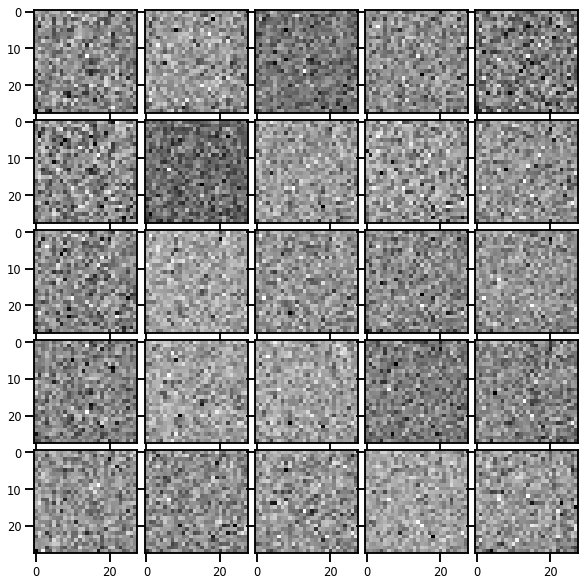

In [14]:
%%time

# forward propagation for data
X_demo_g = gf_model.forward(demo_data_prepped)

# plot demo images
# plot image grid
fig, ax = plot_image_grid(X_demo_g, image_shape)

wandb.log({"initial_latent_images": wandb.Image(plt)})

CPU times: user 4.73 s, sys: 77 ms, total: 4.81 s
Wall time: 4.16 s


(<Figure size 720x720 with 50 Axes>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0x7f94c01a86a0>)

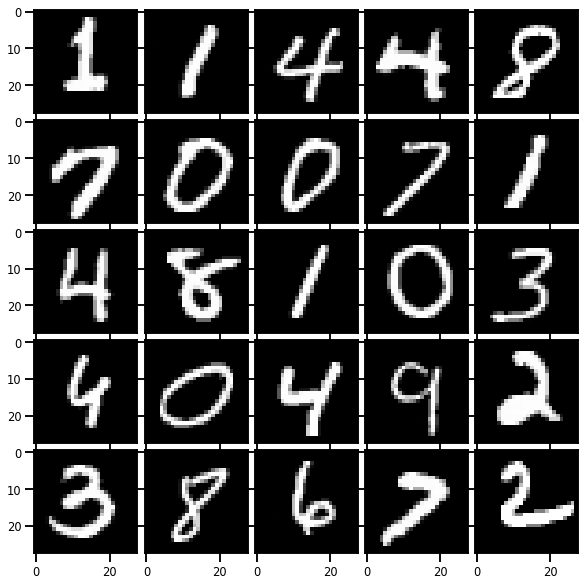

In [40]:
%%time

# forward propagation for data
X_demo_approx = gf_model.inverse(X_demo_g)

# plot demo images
# plot image grid
image_shape = ImageShape(C=1, H=28, W=28)
plot_image_grid(X_demo_approx, image_shape)

### Loss Function

We're going to minimize the log probability

In [15]:
from chex import dataclass


def loss_fn(model: dataclass, prng_key: PRNGKey, batch: Batch) -> Array:

    # prepare data
    data = prepare_data(batch, prng_key)

    # negative log likelihood loss
    nll_loss = model.score(data)

    return nll_loss


def eval_fn(model: dataclass, batch: Batch) -> Array:

    # prepare data
    data = prepare_data(batch)

    # negative log likelihood loss
    nll_loss = model.score(data)

    return nll_loss

#### Demo

In [19]:
nll_loss = loss_fn(gf_model, prng_key, demo_batch)
print(f"Initial NLL Loss (Train): {nll_loss:.4f}")

nll_loss_val = eval_fn(gf_model, demo_batch)

print(f"Initial NLL Loss (Valid): {nll_loss_val:.4f}")

Initial NLL Loss (Train): 3957.6807
Initial NLL Loss (Valid): 3931.4868


## Training

### Optimizer

In [29]:
import optax

# optimizer params
learning_rate = 1e-4

# intialize optimizer
# optimizer = optax.adam(learning_rate=learning_rate)
optimizer = optax.chain(
    optax.scale(1), optax.clip_by_global_norm(1), optax.scale_by_adam(),
)

# intialize optimizer state
opt_state = optimizer.init(gf_model)

### Train Step

In [30]:
from typing import Tuple, Any

OptState = Any


@jax.jit
def update(
    params: dataclass, prng_key: PRNGKey, opt_state: OptState, batch: Batch
) -> Tuple[dataclass, OptState]:
    """Single SGD update step."""
    # calculate the loss AND the gradients
    loss, grads = jax.value_and_grad(loss_fn)(params, prng_key, batch)

    # update the gradients
    updates, new_opt_state = optimizer.update(grads, opt_state)

    # update the parameters
    new_params = optax.apply_updates(params, updates)

    # return loss AND new opt_state
    return new_params, new_opt_state, loss

### Training Loop

In [31]:
# number of epochs
epochs = 500
eval_frequency = 50
# split the keys into a unique subset
train_rng = jax.random.split(rng, num=epochs)

# create an iterator
train_rng = iter(train_rng)

In [32]:
%%wandb

import tqdm


losses = []
valid_losses = []
eval_loss = 0.0
with tqdm.trange(epochs) as pbar:
    for step in pbar:
        gf_model, opt_state, loss = update(
            gf_model, next(train_rng), opt_state, next(train_ds)
        )

        pbar.set_description(f"Train Loss: {loss:.4f} | Valid Loss: {eval_loss:.4f}")
        wandb.log({"train_loss": float(loss), "training_step": step})
        losses.append(loss)
        
        if step % eval_frequency == 0:
            eval_loss = eval_fn(gf_model, next(valid_ds))
            valid_losses.append(eval_loss)
            pbar.set_description(f"Train Loss: {loss:.4f} | Valid Loss: {eval_loss:.4f}")
            wandb.log({"validation_loss": float(eval_loss), "training_step": step})
            losses.append(loss)

Train Loss: nan | Valid Loss: nan:   1%|          | 3/500 [01:43<4:45:30, 34.47s/it]  


KeyboardInterrupt: 

#### Losses

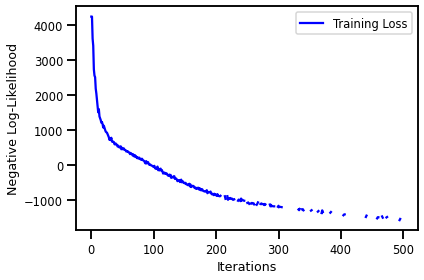

In [24]:
fig, ax = plt.subplots()
ax.plot(losses, label="Training Loss", color="blue")
ax.set(xlabel="Iterations", ylabel="Negative Log-Likelihood")
plt.legend()
plt.tight_layout()
plt.show()

CPU times: user 8.94 s, sys: 1.05 s, total: 9.99 s
Wall time: 5.49 s


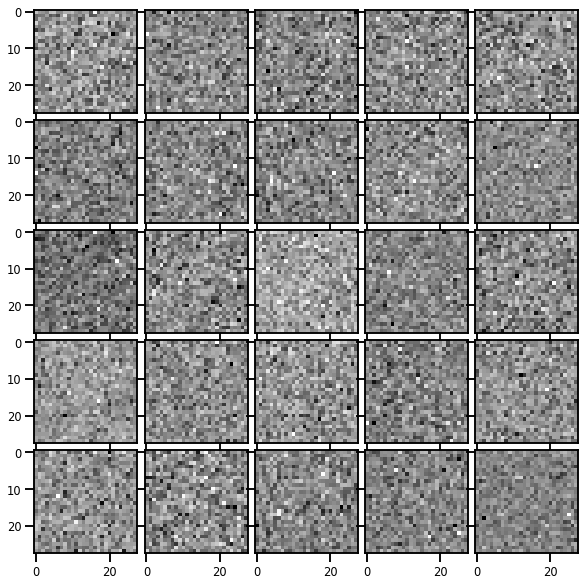

In [25]:
%%time

# forward propagation for data
X_demo_g = gf_model.forward(X_init)

# plot demo images
# plot image grid
fig, ax = plot_image_grid(X_demo_g, image_shape)

wandb.log({"final_latent_images": wandb.Image(plt)})

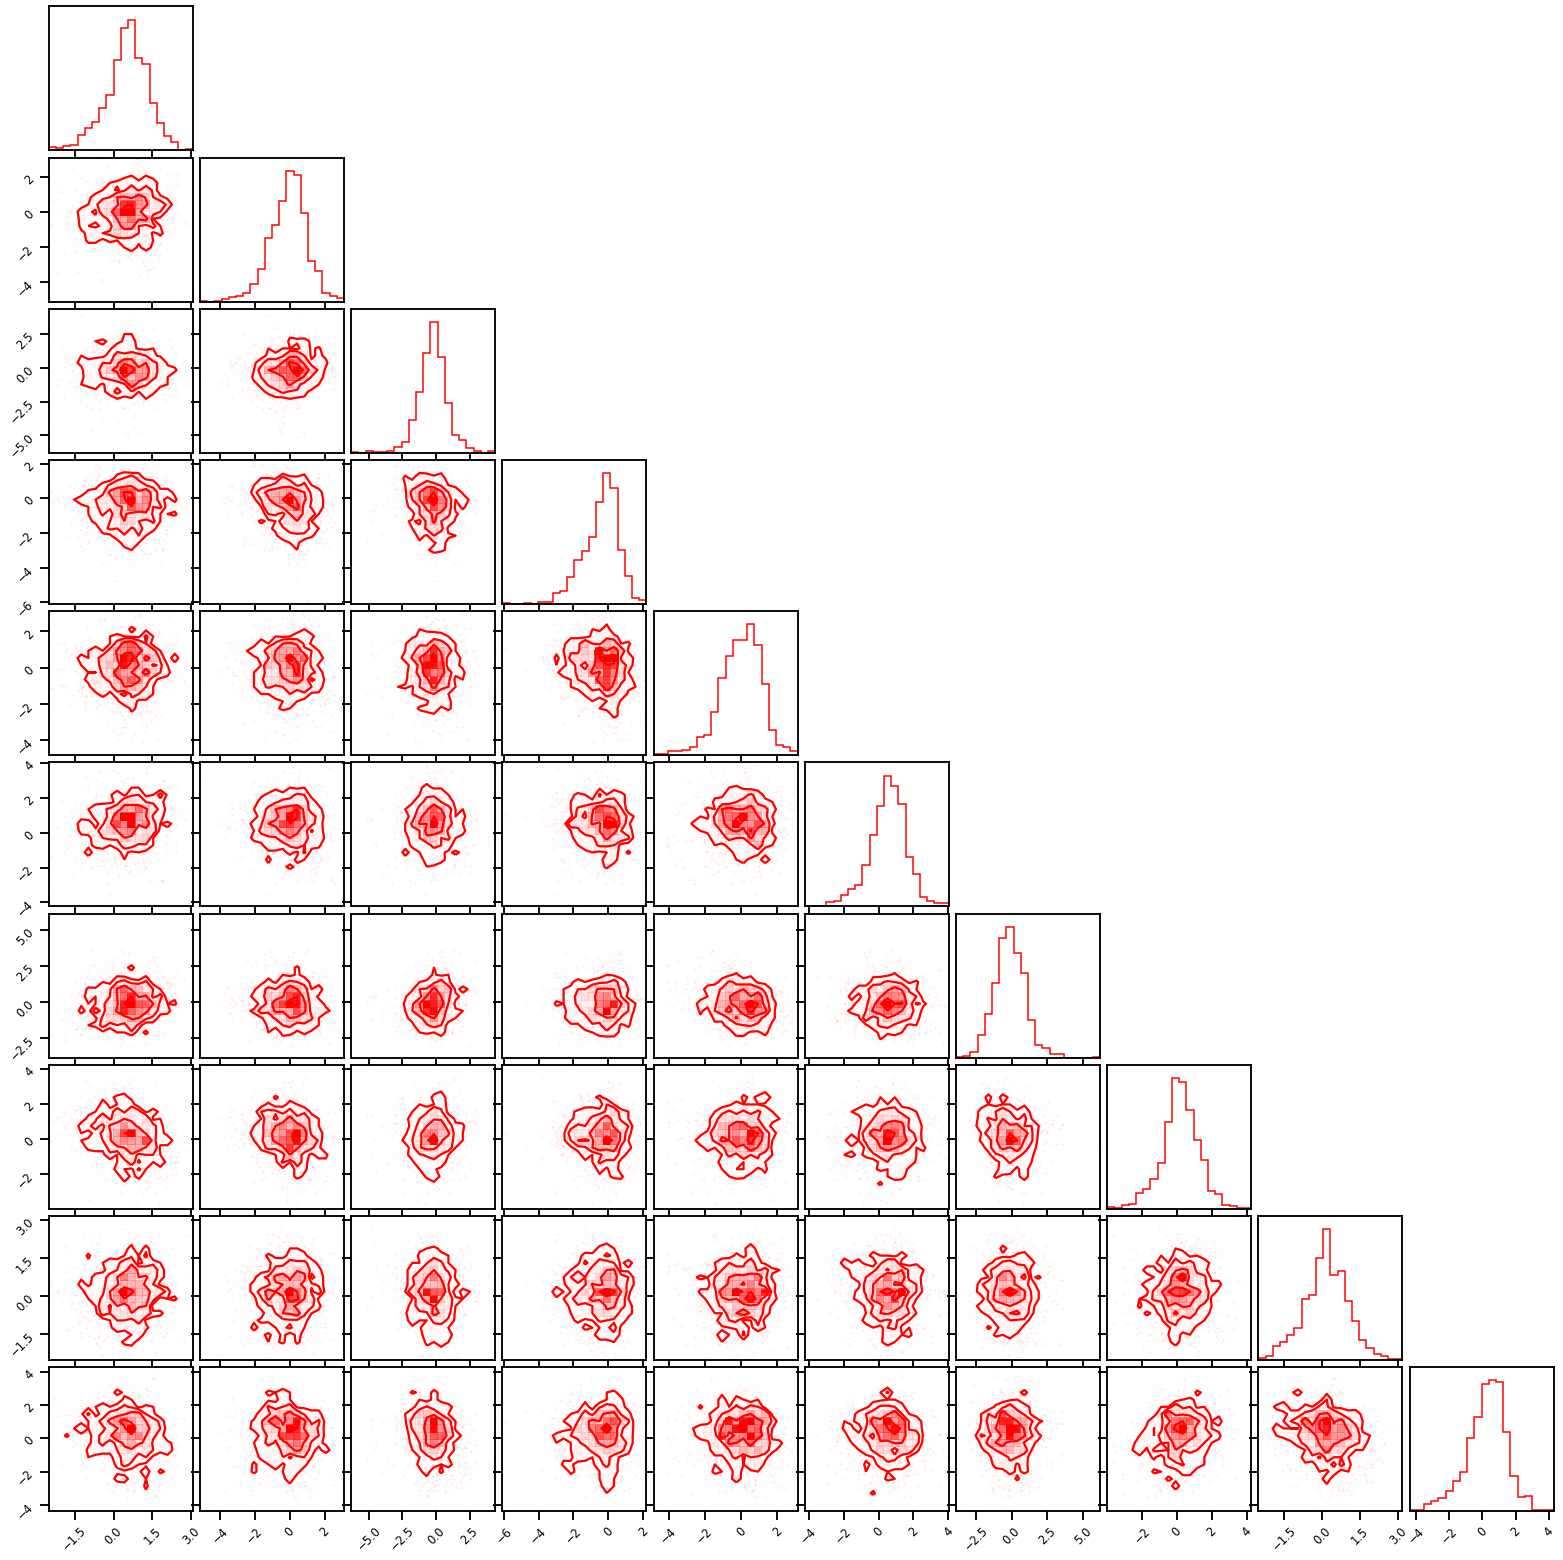

In [26]:
fig = corner.corner(np.array(X_demo_g[:, :10]), color="red")
wandb.log({"final_latent_histogram": wandb.Image(plt)})

CPU times: user 6.16 s, sys: 97.4 ms, total: 6.26 s
Wall time: 5.86 s


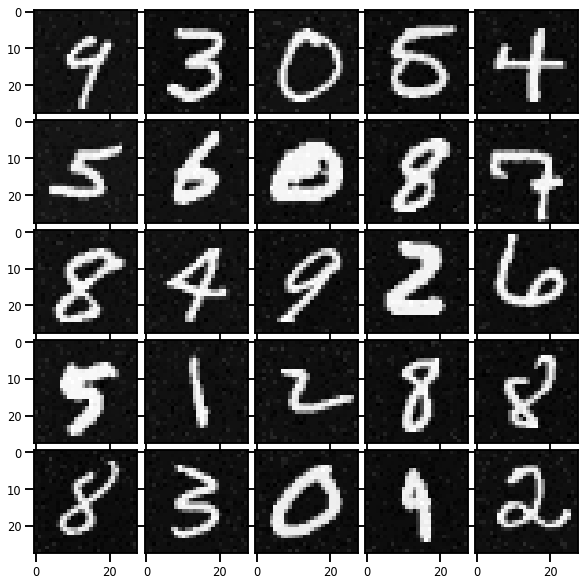

In [27]:
%%time

# forward propagation for data
X_demo_approx = gf_model.inverse(X_demo_g[:50])

# plot demo images
# plot image grid
fig, ax = plot_image_grid(X_demo_approx, image_shape)
# plot image grid

wandb.log({"inverse_transform_images": wandb.Image(plt)})

### Sampling

CPU times: user 6.15 s, sys: 98.1 ms, total: 6.25 s
Wall time: 5.84 s


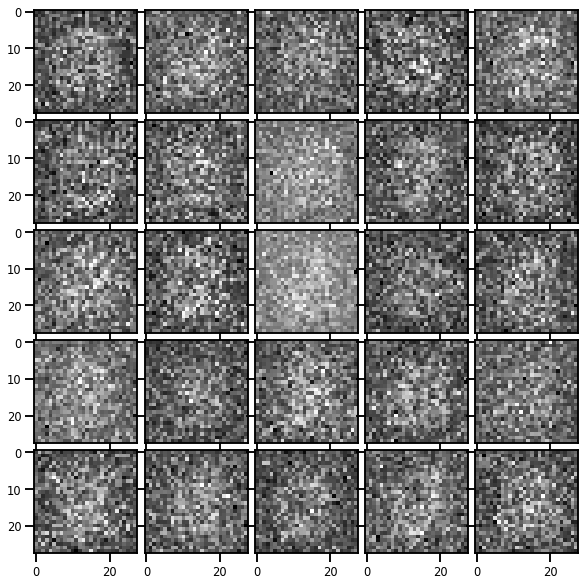

In [28]:
%%time

n_gen_samples = 50
X_samples = gf_model.sample(seed=123, n_samples=n_gen_samples)

# plot
fig, ax = plot_image_grid(X_samples, image_shape)

wandb.log({"generated_samples_images": wandb.Image(plt)})

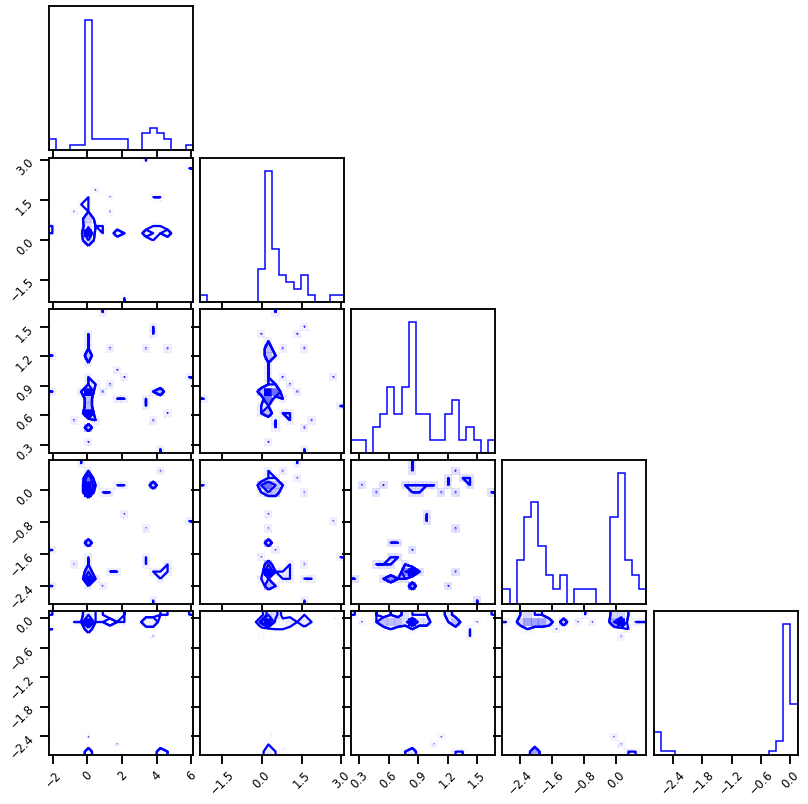

In [49]:
fig = corner.corner(np.array(X_samples[:, :5]), color="Blue")

wandb.log({"generated_samples_histogram": wandb.Image(plt)})

## Each Layer

#### Original

In [ ]:
X_g = X.copy()

fig = corner.corner(X_g, color="purple")
fig.suptitle("Initial")
plt.show()

for ilayer, ibijector in enumerate(gf_model.bijectors):
    
    X_g = ibijector.forward(X_g)
    
    if (ilayer+1) % 3 == 0:
        fig = corner.corner(X_g, color="purple")
        fig.suptitle(f"Block: {(ilayer+1)//3}")
        plt.show()
        
    

#### Trained Model

In [ ]:

X_g = X.copy()

fig = corner.corner(X_g, color="purple")
fig.suptitle("Initial")
plt.show()

for ilayer, ibijector in enumerate(final_bijector.bijectors):
    
    X_g = ibijector.forward(X_g)
    
    if (ilayer+1) % 3 == 0:
        fig = corner.corner(X_g, color="purple")
        fig.suptitle(f"Block: {(ilayer+1)//3}")
        plt.show()
        
    
    

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_g[:, 0], X_g[:, 1], s=3)
ax.set_aspect('equal', 'box')
plt.tight_layout()

## Saving/Loading Model

In [101]:
import joblib

#### Save Model

In [102]:
model_save_name = os.path.join(wandb.run.dir, "gf_model.pckl")
joblib.dump(gf_model, model_save_name)
wandb.save(model_save_name)

['gf_model_mnist.pickle']

#### Load Model

In [103]:
gf_model_ = joblib.load(model_save_name)